<a href="https://colab.research.google.com/github/akshay-chauhan-1810/Project-/blob/main/project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import random


from glob import glob
import librosa.display
import librosa
import os
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Download the train-clean-100 subset (approx 6GB)
LIBRISPEECH_URL = "https://www.openslr.org/resources/12/train-clean-100.tar.gz"
!wget {LIBRISPEECH_URL}

--2025-06-06 14:23:03--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/train-clean-100.tar.gz [following]
--2025-06-06 14:23:04--  https://openslr.elda.org/resources/12/train-clean-100.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz.1’

train-clean-100.tar 100%[===================>]   5.95G  31.2MB/s    in 2m 58s  

2025-06-06 14:26:02 (34.2 MB/s) - ‘train-clean-100.tar.gz.1’ saved [6387309499/6387309499]



In [7]:
 # Extract the files (this may take several minutes)
with tarfile.open('train-clean-100.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [12]:
# Verify the download structure
# !ls LibriSpeech/train-clean-100/
print("\nNumber of speaker directories:", len(os.listdir("LibriSpeech/train-clean-100/")))


Number of speaker directories: 251


In [13]:
audio_files = glob('/content/LibriSpeech/train-clean-100/*/*/*.flac')

In [14]:
# Count number of total audio files
total_audiofile = len(audio_files)
print(f'Total number of audio files: {total_audiofile}')

Total number of audio files: 28539


In [15]:
# Sort files
audio_files.sort()

In [16]:
# Check the file path
audio_files[0]

'/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac'

In [17]:
# Play Audio file
ipd.Audio(audio_files[0])

In [10]:
samples, sample_rate = librosa.load(audio_files[0])
print(f'samples: {samples[:50]}')
print(f'anotehr samples: {samples[30000:30050]}')
print(f'shape of samples: {samples.shape}')
print(f'sample_rate: {sample_rate}')

samples: [-0.00605447 -0.00620023 -0.00534335 -0.00625998 -0.00642866 -0.00627569
 -0.00689894 -0.00650041 -0.00575081 -0.00575456 -0.00569828 -0.00589117
 -0.00608362 -0.00545392 -0.00508875 -0.00517563 -0.00475007 -0.00425545
 -0.00401232 -0.00390697 -0.00412092 -0.00415715 -0.00407751 -0.00452834
 -0.00490445 -0.00480064 -0.00458062 -0.00423252 -0.00424555 -0.00467728
 -0.00437614 -0.00376545 -0.00404761 -0.00423071 -0.00360352 -0.0036559
 -0.00463291 -0.0046873  -0.00379505 -0.00378523 -0.00430914 -0.00403157
 -0.00378463 -0.00379231 -0.00304547 -0.00272624 -0.00347473 -0.00341886
 -0.0028232  -0.00309526]
anotehr samples: [0.00482023 0.00554903 0.00520891 0.00418736 0.00462876 0.00474332
 0.00369828 0.00357691 0.00403647 0.00413265 0.00418527 0.00393602
 0.00393974 0.004341   0.00382874 0.00320439 0.00353273 0.00353942
 0.00332119 0.00395028 0.00457572 0.00440289 0.00376627 0.0034914
 0.004204   0.0047008  0.00415346 0.0040763  0.00447235 0.00392977
 0.00343296 0.00381831 0.003809

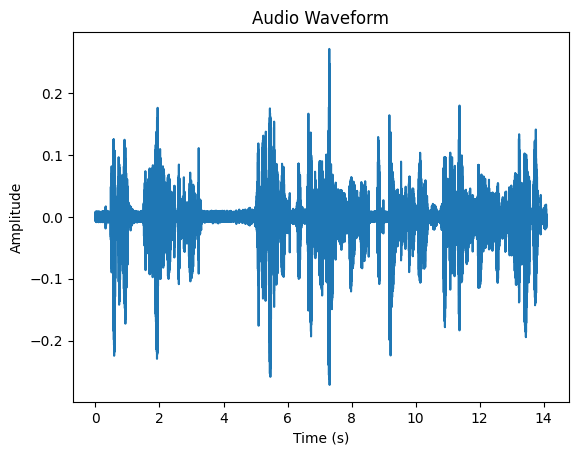

In [11]:
time = np.linspace(0, len(samples)/sample_rate, len(samples))
plt.plot(time, samples)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

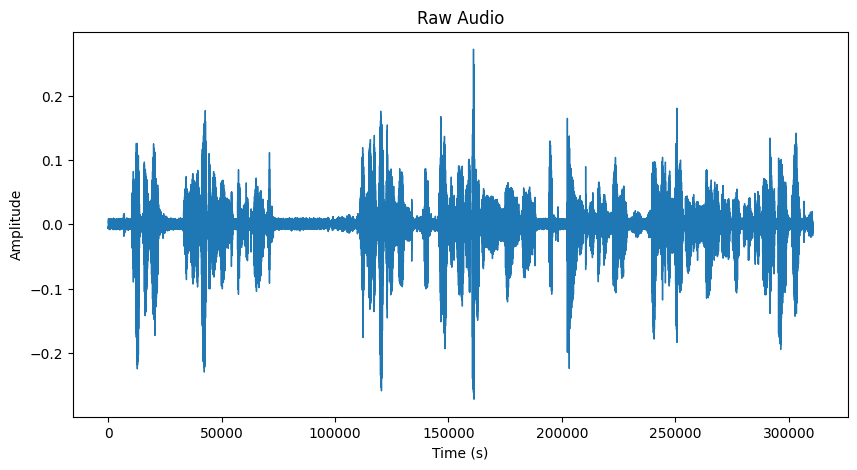

In [12]:
pd.Series(samples).plot(figsize=(10, 5),
                        lw=1,
                        title='Raw Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

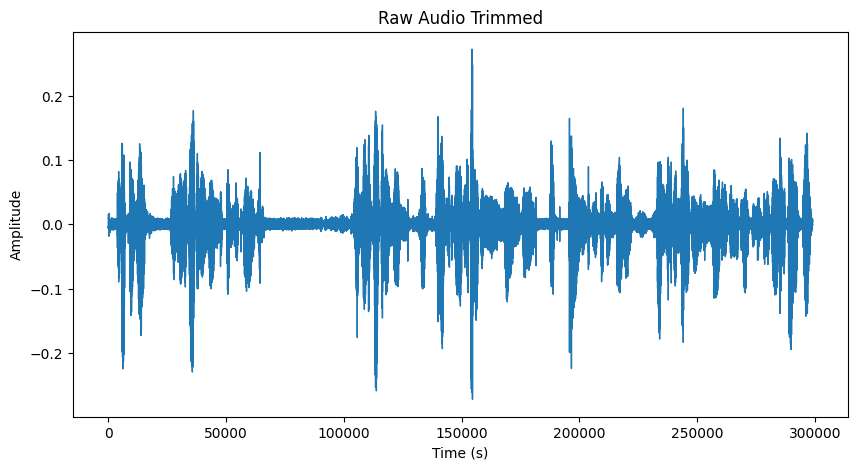

In [13]:
# Trimming leading/lagging silence
samples_trimmed, _ = librosa.effects.trim(samples, top_db=20)
pd.Series(samples_trimmed).plot(figsize=(10, 5),
                                lw=1,
                                title='Raw Audio Trimmed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

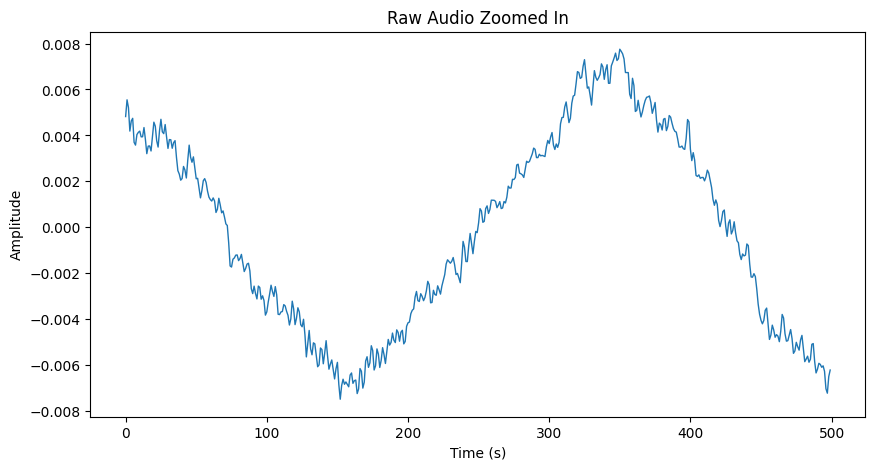

In [14]:
pd.Series(samples[30000:30500]).plot(figsize=(10, 5),
                                     lw=1,
                                     title='Raw Audio Zoomed In')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [15]:
# Collect all transcript files
transcript_files = glob(os.path.join('/content/LibriSpeech/train-clean-100', '*/*/*.trans.txt'))
print(transcript_files[0])

/content/LibriSpeech/train-clean-100/6437/66172/6437-66172.trans.txt


In [16]:
data = []
for file in transcript_files:
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            file_id = parts[0]
            transcript = parts[1]
            speaker_id = file.split('/')[-3]
            chapter_id = file.split('/')[-2]
            flac_path = os.path.join(os.path.dirname(file), f"{file_id}.flac")
            data.append((file_id, speaker_id, chapter_id, flac_path, transcript))

df_sample = pd.DataFrame(data, columns=['file_id', 'speaker_id', 'chapter_id', 'flac_path', 'transcript'])

In [17]:
df_sample.head()

,file_id,speaker_id,chapter_id,flac_path,transcript
0,6437-66172-0000,6437,66172,/content/LibriSpeech/train-clean-100/6437/6617...,IN THE COURSE OF TEN DAYS I RECOVERED SUFFICIE...
1,6437-66172-0001,6437,66172,/content/LibriSpeech/train-clean-100/6437/6617...,THE DISTRACTION WHICH PREVAILED IN THE CLASSES...
2,6437-66172-0002,6437,66172,/content/LibriSpeech/train-clean-100/6437/6617...,IN AUGUST WE HAD TWO WEEKS VACATION IT WAS ABO...
3,6437-66172-0003,6437,66172,/content/LibriSpeech/train-clean-100/6437/6617...,THIS WAS AN HONOR TO WHICH I HAD LONG ASPIRED ...
4,6437-66172-0004,6437,66172,/content/LibriSpeech/train-clean-100/6437/6617...,THOUGH I WAS AN ACTIVE MEMBER OF THE BODY DURI...


In [18]:
def extract_metadata(path):
  parts = path.split('/')
  return {
      'speaker_id': parts[-3],
      'chapter_id': parts[-2],
      'utterance_id': parts[-1].split('.')[0].split('-')[-1],
      'path': path
  }

metadata = [extract_metadata(path) for path in audio_files]
metadata_df = pd.DataFrame(metadata)

# Convert ID to numeric
metadata_df['speaker_id'] = pd.to_numeric(metadata_df['speaker_id'])
metadata_df['chapter_id'] = pd.to_numeric(metadata_df['chapter_id'])
metadata_df['utterance_id'] = pd.to_numeric(metadata_df['utterance_id'])

In [19]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28539 entries, 0 to 28538
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   speaker_id    28539 non-null  int64 
 1   chapter_id    28539 non-null  int64 
 2   utterance_id  28539 non-null  int64 
 3   path          28539 non-null  object
dtypes: int64(3), object(1)
memory usage: 892.0+ KB


In [20]:
metadata_df.isna().sum()

,0
speaker_id,0
chapter_id,0
utterance_id,0
path,0


In [21]:
metadata_df.head()

,speaker_id,chapter_id,utterance_id,path
0,103,1240,0,/content/LibriSpeech/train-clean-100/103/1240/...
1,103,1240,1,/content/LibriSpeech/train-clean-100/103/1240/...
2,103,1240,2,/content/LibriSpeech/train-clean-100/103/1240/...
3,103,1240,3,/content/LibriSpeech/train-clean-100/103/1240/...
4,103,1240,4,/content/LibriSpeech/train-clean-100/103/1240/...


In [22]:
metadata_df.describe()

,speaker_id,chapter_id,utterance_id
count,28539.000000,28539.000000,28539.000000
mean,3807.547216,116990.727776,29.114860
std,2780.342240,82998.820066,23.198393
min,19.000000,198.000000,0.000000
25%,1116.000000,41615.000000,12.000000
50%,3664.000000,123523.000000,24.000000
75%,6181.000000,152139.000000,40.000000
max,8975.000000,305213.000000,132.000000


## **Speaker Distribution**

Number of unique speakers: 251


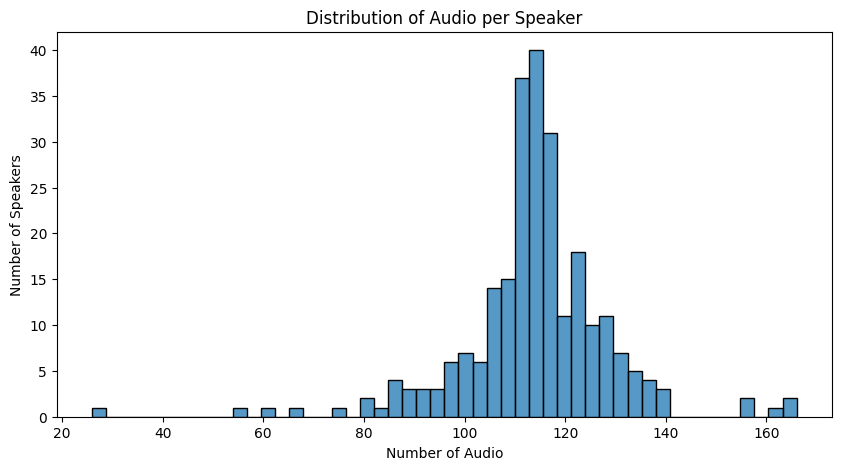

In [ ]:
# Number of unique speakers
num_speakers = metadata_df['speaker_id'].nunique()
print(f'Number of unique speakers: {num_speakers}')

# Distribution of audio per speaker
audio_per_speaker = metadata_df['speaker_id'].value_counts()
# print(audio_per_speaker)

plt.figure(figsize=(10, 5))
sns.histplot(audio_per_speaker, bins=50)
plt.title('Distribution of Audio per Speaker')
plt.xlabel('Number of Audio')
plt.ylabel('Number of Speakers')
plt.show()

## **Audio** **Duration** **Analysis**

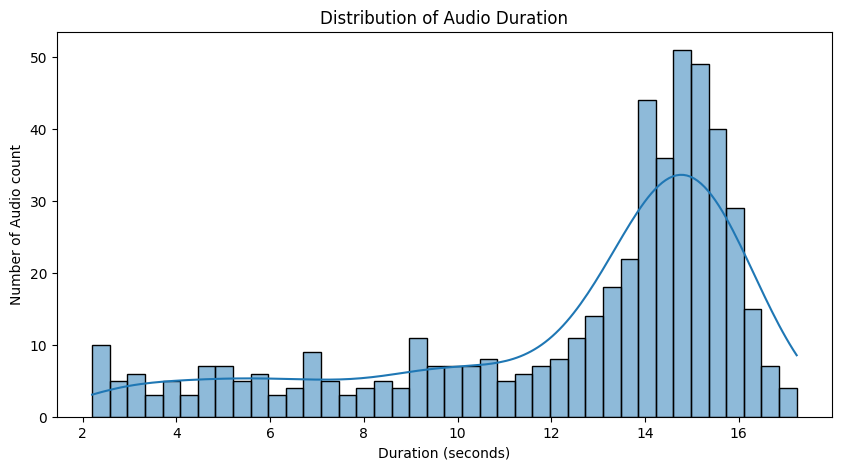

In [ ]:
duration = []
# Sample first 500 files to get duration
for f in audio_files[:500]:
  y, sr = librosa.load(f, sr=None)
  duration.append(len(y)/sr)

plt.figure(figsize=(10, 5))
sns.histplot(duration, bins=40, kde=True)
plt.title('Distribution of Audio Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Audio count')
plt.show()

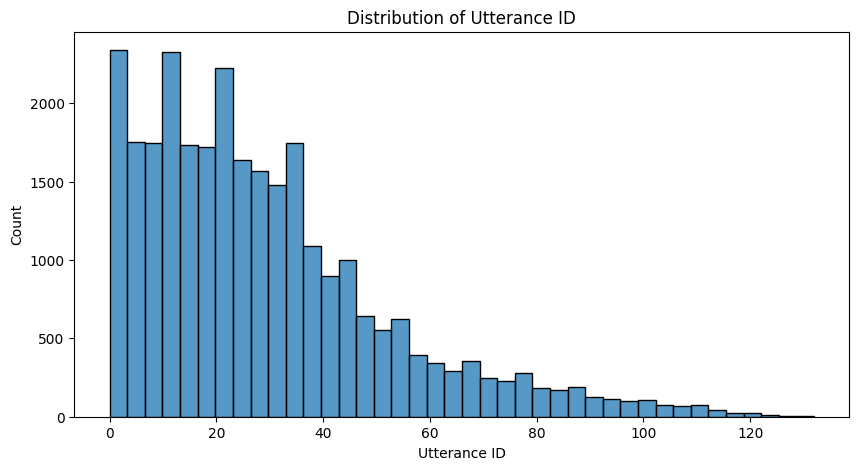

In [ ]:
# Distribution of utterance ID
plt.figure(figsize=(10, 5))
sns.histplot(metadata_df['utterance_id'], bins=40)
plt.title('Distribution of Utterance ID')
plt.xlabel('Utterance ID')
plt.ylabel('Count')
plt.show()

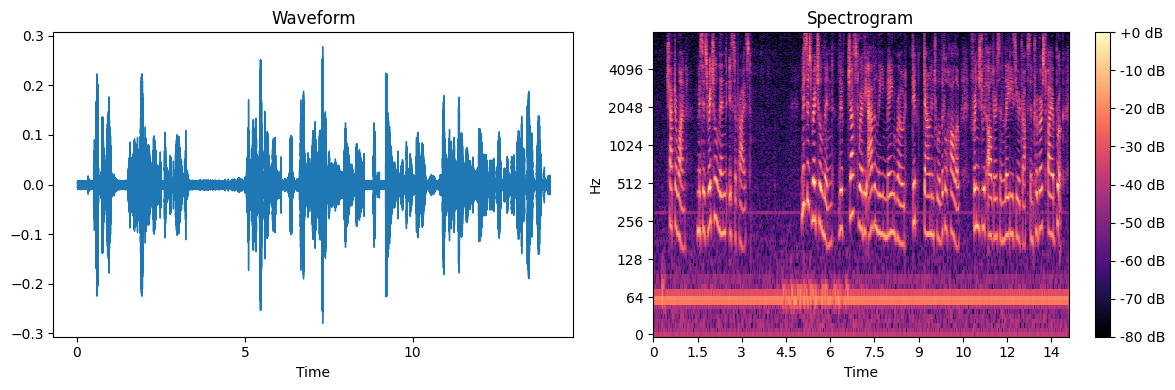

In [23]:
# Waveform and Spectrogram Visualization

# path = '/content/LibriSpeech/train-clean-100/*/*/*.flac'

def plot_waveform_spectrogram(path):
    y, sr = librosa.load(path, sr=None)
    plt.figure(figsize=(12, 4))

    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")


    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")

    plt.tight_layout()
    plt.show()

# Visualize one sample
# plot_waveform_spectrogram(df_sample['flac_path'].iloc[0])
plot_waveform_spectrogram(audio_files[0])


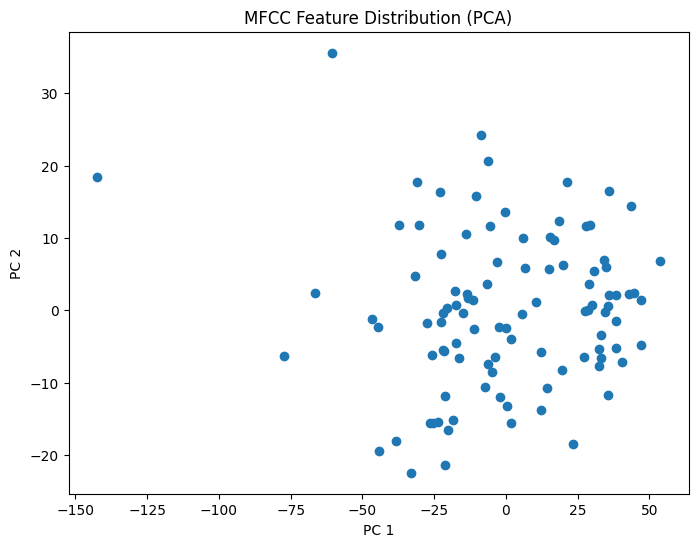

In [ ]:
def extract_features(path):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc.mean(axis=1)

# Extract MFCCs for first 100 samples
mfcc_features = df_sample['flac_path'].iloc[:100].apply(extract_features)
mfcc_matrix = np.vstack(mfcc_features.values)


# PCA to 2D
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(mfcc_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('MFCC Feature Distribution (PCA)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.savefig("mfcc_pca.jpg")
plt.show()

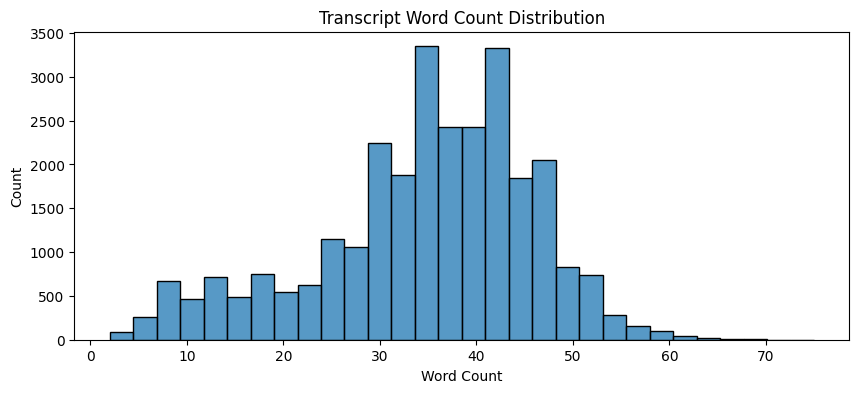

In [24]:
# Transcript Analysis
df_sample['word_count'] = df_sample['transcript'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 4))
sns.histplot(df_sample['word_count'], bins=30)
plt.title('Transcript Word Count Distribution')
plt.xlabel('Word Count')
plt.show()

# df_sample['word_count']

In [25]:
y, sr = librosa.load(audio_files[0])

In [26]:
y

array([-0.00605447, -0.00620023, -0.00534335, ..., -0.00489496,
       -0.00899089,  0.        ], dtype=float32)

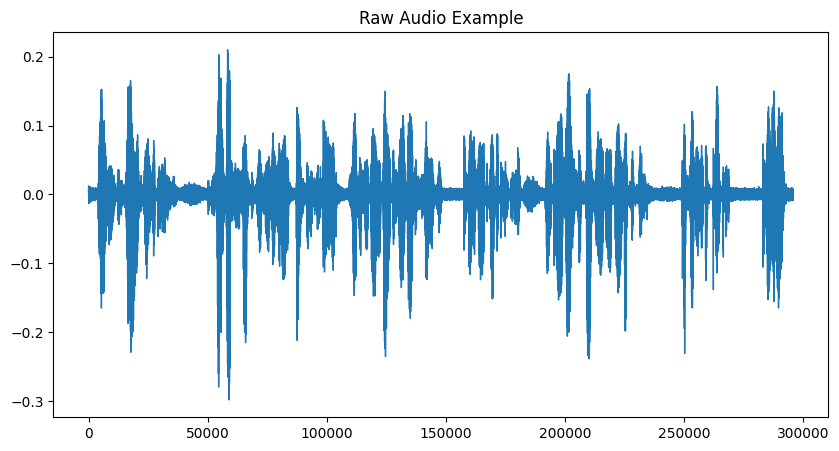

In [ ]:
pd.Series(y).plot(figsize=(10,5), lw=1, title="Raw Audio Example")
plt.show()

In [27]:
librosa.effects.trim(y)

(array([-0.00605447, -0.00620023, -0.00534335, ..., -0.00489496,
        -0.00899089,  0.        ], dtype=float32),
 array([     0, 310575]))

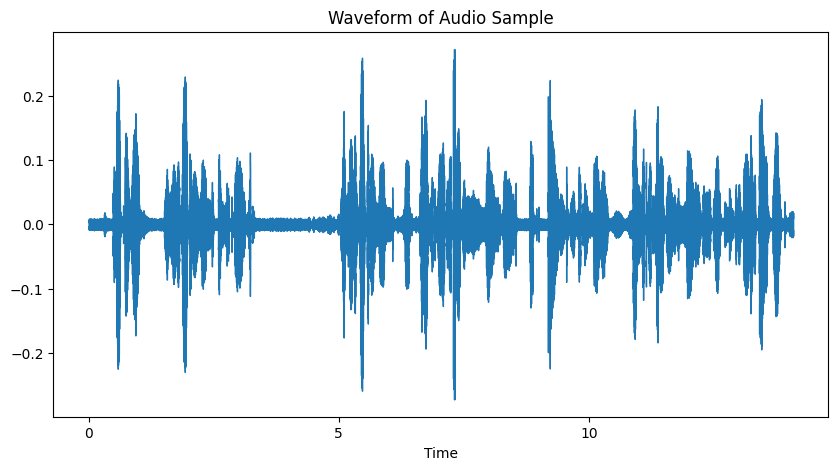

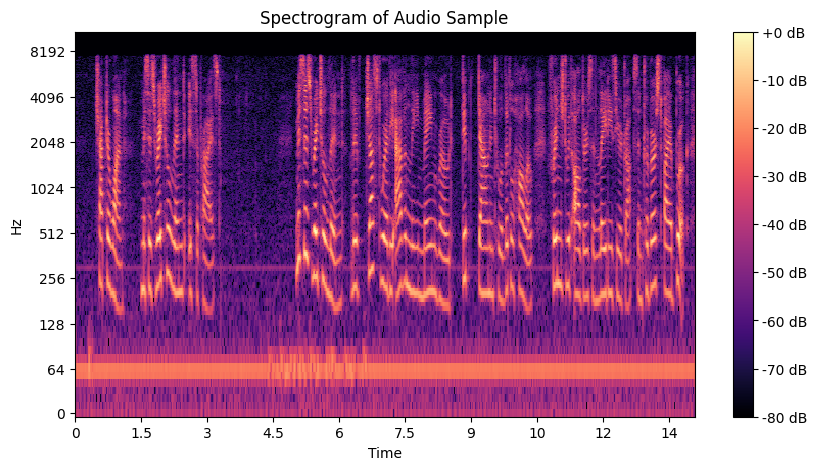

In [28]:
# Plot waveform

plt.figure(figsize=(10, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Audio Sample')
plt.show()

# Plot spectrogram
plt.figure(figsize=(10, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Audio Sample')
plt.show()

In [ ]:
path1 = '/content/LibriSpeech/train-clean-100'
speaker_utterances = {}
for root, dirs, files in os.walk(path1):
    for file in files:
        if file.endswith(".flac"):
            speaker_id = root.split("/")[-2]  # Get speaker ID from path
            full_path = os.path.join(root, file)
            speaker_utterances.setdefault(speaker_id, []).append(full_path)

speaker_utterances = {k: v for k, v in speaker_utterances.items() if len(v) >= 2}

In [ ]:
selected_speakers = random.sample(list(speaker_utterances.keys()), 20)


In [ ]:
import random
from itertools import combinations


# Reduce size for demo
df_small = df.groupby('speaker_id').filter(lambda x: len(x) >= 2)
speakers = df_small['speaker_id'].unique()

# Generate same-speaker pairs
same_pairs = []
for spk in random.sample(list(speakers), 100):  # 100 speakers
    spk_samples = df_small[df_small['speaker_id'] == spk]['flac_path'].tolist()
    if len(spk_samples) >= 2:
        pairs = list(combinations(spk_samples, 2))[:1]  # 1 same pair per speaker
        same_pairs.extend([(a, b, 1) for a, b in pairs])

# Generate different-speaker pairs
diff_pairs = []
for _ in range(len(same_pairs)):
    spk1, spk2 = random.sample(list(speakers), 2)
    a = df_small[df_small['speaker_id'] == spk1].sample(1)['flac_path'].values[0]
    b = df_small[df_small['speaker_id'] == spk2].sample(1)['flac_path'].values[0]
    diff_pairs.append((a, b, 0))

# Combine
pairs_df = pd.DataFrame(same_pairs + diff_pairs, columns=['path_1', 'path_2', 'label'])
labels = [1] * len(same_pairs) + [0] * len(diff_pairs)

In [ ]:
# print(f"Generated {len(same_pairs)} same-speaker pairs and {len(diff_pairs)} different-speaker pairs.")
# print(f"Total pairs for training: {len(pairs_df)}")

pairs_df.shape

(200, 3)

In [ ]:
# Using SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Convert pairs to feature differences
X_pairs = []
for index, pair in pairs_df.iterrows():
    # Now 'pair' is a Pandas Series representing the row
    emb1 = extract_features(pair['path_1'])  # Reuse Step 2's feature extraction
    emb2 = extract_features(pair['path_2'])
    X_pairs.append(np.abs(emb1 - emb2))  # Absolute difference


    similarity = cosine_similarity([emb1], [emb2])[0][0]
    print(f"Similarity: {similarity:.4f}")

X_train, X_test, y_train, y_test = train_test_split(X_pairs, labels)
model = SVC(kernel="linear")
model.fit(X_train, y_train)
print("Accuracy:", model.score(X_test, y_test))

[-0.00115967 -0.00073242 -0.00097656 ... -0.00357056 -0.00320435
 -0.0043335 ] 16000
[-0.00350952 -0.00170898 -0.0007019  ... -0.00073242  0.00015259
  0.00076294] 16000
Similarity: 0.9989
[-0.00213623 -0.00158691 -0.00219727 ... -0.00653076 -0.00778198
 -0.0083313 ] 16000
[ 0.01257324  0.00601196  0.00457764 ... -0.00454712 -0.00424194
 -0.00540161] 16000
Similarity: 0.9995
[-0.00402832 -0.00238037  0.00076294 ...  0.01751709  0.01861572
  0.01831055] 16000
[-0.00994873 -0.00939941 -0.01257324 ...  0.00375366  0.00363159
  0.00338745] 16000
Similarity: 0.9976
[-0.00595093 -0.00604248 -0.00585938 ... -0.00219727 -0.00228882
 -0.00244141] 16000
[-0.00247192 -0.00244141 -0.00271606 ...  0.00323486  0.00354004
  0.00262451] 16000
Similarity: 1.0000
[ 5.4931641e-04  3.0517578e-04  2.1362305e-04 ... -8.8500977e-04
 -4.5776367e-04  3.0517578e-05] 16000
[-0.00244141 -0.00408936 -0.00305176 ...  0.00036621 -0.00027466
 -0.00067139] 16000
Similarity: 0.9951
[0.00033569 0.00030518 0.00030518 ...

In [ ]:
# STEP 3: Feature Extraction Function
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    print(y, sr)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = pitches[magnitudes > np.median(magnitudes)].mean() if np.any(magnitudes > 0) else 0

    # Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0].mean()


    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)[0].mean()

    # Combine features
    return np.hstack([mfccs_mean, pitch, rolloff, zcr])


In [ ]:
# STEP 4: Load Data
def load_data(base_path='/content/LibriSpeech/train-clean-100', max_speakers=10, max_files_per_speaker=20):
    X, y = [], []
    speakers = sorted(os.listdir(base_path))[:max_speakers]
    for speaker_id in speakers:
        speaker_path = os.path.join(base_path, speaker_id)
        for chapter in os.listdir(speaker_path):
            chapter_path = os.path.join(speaker_path, chapter)
            for i, file in enumerate(os.listdir(chapter_path)):
                if file.endswith('.flac') and i < max_files_per_speaker:
                    try:
                        file_path = os.path.join(chapter_path, file)
                        features = extract_features(file_path)
                        X.append(features)
                        y.append(speaker_id)
                    except Exception as e:
                        print(f"Skipped {file_path}: {e}")
    return np.array(X), np.array(y)

print("Extracting features...")
X, y = load_data()

Extracting features...
[ 0.00384521  0.00375366  0.00543213 ...  0.01647949  0.00793457
 -0.00479126] 16000
[-0.00817871 -0.00750732 -0.00805664 ...  0.00479126  0.00411987
  0.00427246] 16000
[-0.00454712 -0.00387573 -0.00439453 ... -0.00210571 -0.00250244
 -0.00234985] 16000
[ 0.00115967  0.00280762 -0.01599121 ...  0.00289917  0.00317383
  0.00308228] 16000
[-0.00320435 -0.00421143 -0.00201416 ... -0.00323486 -0.00393677
 -0.00576782] 16000
[ 0.0022583   0.00234985  0.00167847 ... -0.00473022 -0.00268555
 -0.00561523] 16000
[ 0.00430298  0.00369263  0.00219727 ... -0.00662231 -0.00717163
 -0.00756836] 16000
[0.00564575 0.00497437 0.00457764 ... 0.01144409 0.00921631 0.00421143] 16000
[0.01248169 0.00564575 0.00085449 ... 0.00717163 0.00756836 0.0078125 ] 16000
[-0.00030518 -0.00109863 -0.00216675 ...  0.00491333  0.00805664
  0.00906372] 16000
[-0.0007019   0.00015259  0.00128174 ...  0.00650024  0.00619507
  0.00692749] 16000
[-0.00598145 -0.00708008 -0.00817871 ...  0.01202393  0.

In [ ]:
X[0]

array([-3.35520569e+02,  5.65812912e+01, -5.04522443e-01,  3.09745903e+01,
       -6.45551729e+00, -8.05076122e+00, -5.96081686e+00,  1.03928909e+01,
       -2.52489305e+00,  4.23631287e+00,  3.27756500e+00,  4.72097969e+00,
        6.70886374e+00,  1.76404211e+03,  4.24607878e+03,  1.24242322e-01])

In [ ]:
y

array(['103', '103', '103', '103', '103', '103', '103', '103', '103',
       '103', '103', '103', '103', '103', '103', '103', '103', '103',
       '103', '103', '103', '103', '103', '103', '103', '103', '103',
       '103', '103', '103', '103', '103', '103', '103', '103', '103',
       '103', '103', '1034', '1034', '1034', '1034', '1034', '1034',
       '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034',
       '1034', '1034', '1034', '1034', '1034', '1034', '1040', '1040',
       '1040', '1040', '1040', '1040', '1040', '1040', '1040', '1040',
       '1040', '1040', '1040', '1040', '1040', '1040', '1040', '1040',
       '1040', '1040', '1069', '1069', '1069', '1069', '1069', '1069',
       '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069',
       '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069',
       '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069',
       '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069',
       '1069

In [ ]:
# df = pd.DataFrame({'label': y})
# class_dist = df['label'].value_counts().sort_index()

# print("Class Distribution:")
# print(class_dist)


### **Speech to Text**

In [ ]:
!pip install faster-whisper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
from faster_whisper import WhisperModel

model_size = "large"


In [ ]:
model = WhisperModel(model_size, device="cpu", compute_type="int8")

segments, info = model.transcribe("/content/27-124992-0000.flac", beam_size=5)

# df_sample['flac_path'].iloc[:100].apply(extract_features)

print("Detected language '%s' with probability %f" % (info.language, info.language_probability))

for segment in segments:
    print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))

Detected language 'en' with probability 0.999730
[0.00s -> 16.90s]  is generally believed to be the high priest eliakim called also joachim the transactions herein related most probably happened in his days and in the reign of manassas after his repentance and return from captivity


**Implement Using Pretrain model VoiceEncoder - resemblyzer**

In [1]:
!pip install resemblyzer

In [4]:
from resemblyzer import preprocess_wav, VoiceEncoder

encoder = VoiceEncoder("cpu")
wav1 = preprocess_wav('/content/LibriSpeech/train-clean-100/1723/141149/1723-141149-0003.flac')
wav2 = preprocess_wav('/content/LibriSpeech/train-clean-100/1723/141149/1723-141149-0013.flac')

emd1 = encoder.embed_utterance(wav1)
emd2 = encoder.embed_utterance(wav2)

similarity = np.dot(emd1, emd2) / (np.linalg.norm(emd1) * np.linalg.norm(emd2))
print(similarity)

Loaded the voice encoder model on cpu in 0.02 seconds.
0.9500014


In [69]:
threshold = 0.90

In [70]:
sample_file = random.sample(audio_files, 10)
sample_file

['/content/LibriSpeech/train-clean-100/7780/274562/7780-274562-0083.flac',
 '/content/LibriSpeech/train-clean-100/5688/41232/5688-41232-0020.flac',
 '/content/LibriSpeech/train-clean-100/4640/19188/4640-19188-0037.flac',
 '/content/LibriSpeech/train-clean-100/200/126784/200-126784-0032.flac',
 '/content/LibriSpeech/train-clean-100/8465/246942/8465-246942-0027.flac',
 '/content/LibriSpeech/train-clean-100/5463/39173/5463-39173-0055.flac',
 '/content/LibriSpeech/train-clean-100/4397/15668/4397-15668-0018.flac',
 '/content/LibriSpeech/train-clean-100/5192/19397/5192-19397-0019.flac',
 '/content/LibriSpeech/train-clean-100/1263/139804/1263-139804-0001.flac',
 '/content/LibriSpeech/train-clean-100/4406/16882/4406-16882-0011.flac']

In [71]:
embeddings = []
for file in sample_file:
  wav = preprocess_wav(file)
  embeddings.append(encoder.embed_utterance(wav))

In [72]:
similarity_matrix = np.zeros((len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
  for j in range(len(embeddings)):
    # similarity_matrix[i][j] = np.dot(embeddings[i], embeddings[j])
    dot = np.dot(embeddings[i], embeddings[j])
    norm = np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j])
    similarity_matrix[i][j] = dot / norm

<Axes: >

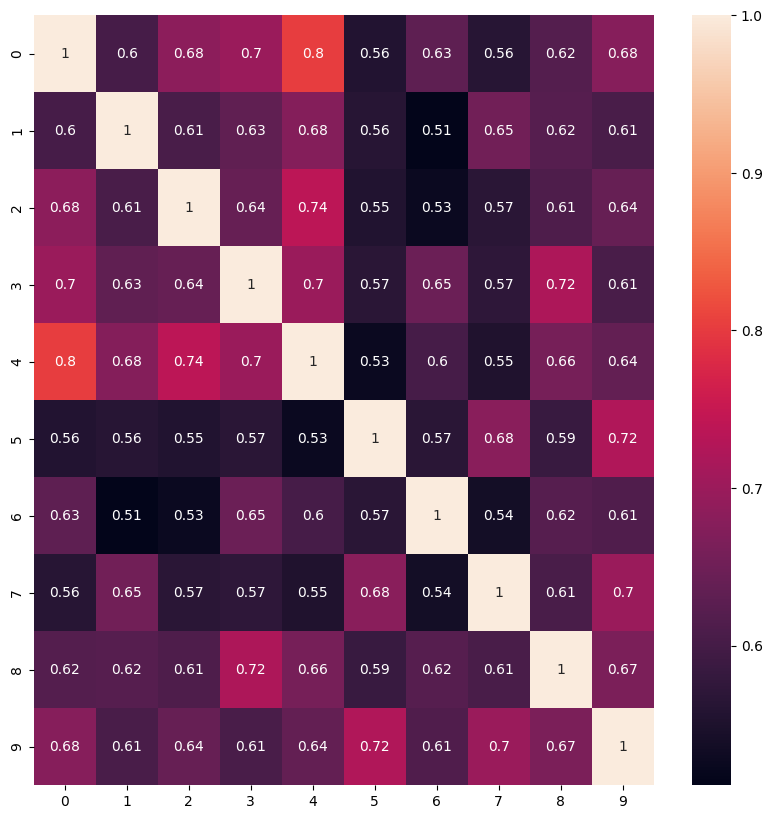

In [73]:
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix, annot=True)

In [74]:
similar_pairs = []
for i in range(len(embeddings)):
  for j in range(i+1, len(embeddings)):
    sim = similarity_matrix[i,j]
    if sim >= threshold:
      similar_pairs.append((sample_file[i], sample_file[j], sim))

In [75]:
for i, j, sim in similar_pairs:
  print(f" sample {i} and sample {j} are similar with similarity {sim}")

In [76]:
print(len(similar_pairs))

0
